# Pre-processing and cleaning approved drugs (ChEMBL Web Resource)

In this step, we drop some missing and irrelevant stuff and reorder stuff. The objective of this notebook is to do the pre-cleaning and cleaning of the dataset gathered from ChEMBL Web Resource. More info about it below.

The ChEMBL Web Resource, as defined by the authors and mantainers in [GitHub](https://github.com/chembl/chembl_webresource_client): *'The library helps accessing ChEMBL data and cheminformatics tools from Python. You don't need to know how to write SQL. You don't need to know how to interact with REST APIs. You don't need to compile or install any cheminformatics frameworks. Results are cached.'*

## Importing packages and data

This section is dedicated to **import the packages and libraries** that we're going to use in this notebook, aswell as **the data** retrieved from *ChEMBL Web Resource* (more info above).

In [1]:
# Importing libraries
from rdkit import Chem, rdBase
from rdkit.Chem import Draw, Descriptors, PandasTools, AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.SaltRemover import SaltRemover, InputFormat
import pandas as pd
import re

# Defining a function to print the mol image more than once
from IPython.display import HTML
def show_df(df):
    return HTML(df.to_html(notebook=True))

In [2]:
# Importing the dataset:
approved_drugs_df = pd.read_csv('data/RAW_approved_drugs.csv')

## Step 1 - Pre-process

Taking a peek into the data we can see that there are a lot of variables that we don't need aswell as some rows depicting "NaN". We need to filter the bulk of information then refine it. This is the objective of the pre-process step.

In [3]:
# List of variables
print(approved_drugs_df.columns, "\n\n",approved_drugs_df.shape )
# Taking a peek into the data
approved_drugs_df.head(5)

Index(['atc_classifications', 'availability_type', 'biotherapeutic',
       'black_box_warning', 'chebi_par_id', 'chirality', 'cross_references',
       'dosed_ingredient', 'first_approval', 'first_in_class', 'helm_notation',
       'indication_class', 'inorganic_flag', 'max_phase', 'molecule_chembl_id',
       'molecule_hierarchy', 'molecule_properties', 'molecule_structures',
       'molecule_synonyms', 'molecule_type', 'natural_product', 'oral',
       'parenteral', 'polymer_flag', 'pref_name', 'prodrug', 'structure_type',
       'therapeutic_flag', 'topical', 'usan_stem', 'usan_stem_definition',
       'usan_substem', 'usan_year', 'withdrawn_class', 'withdrawn_country',
       'withdrawn_flag', 'withdrawn_reason', 'withdrawn_year', 'SMILES'],
      dtype='object') 

 (4121, 39)


,atc_classifications,availability_type,biotherapeutic,black_box_warning,chebi_par_id,chirality,cross_references,dosed_ingredient,first_approval,first_in_class,...,usan_stem,usan_stem_definition,usan_substem,usan_year,withdrawn_class,withdrawn_country,withdrawn_flag,withdrawn_reason,withdrawn_year,SMILES
0,['V03AN03'],1,NaN,0,30217.0,2,[],True,2015.0,0,...,-ium,quaternary ammonium derivatives,-ium,NaN,NaN,NaN,False,NaN,NaN,[He]
1,[],1,NaN,0,16134.0,2,"[{'xref_id': 'ammonia%20n-13', 'xref_name': 'a...",False,2007.0,0,...,NaN,NaN,NaN,1990.0,NaN,NaN,False,NaN,NaN,N
2,[],1,NaN,0,NaN,2,"[{'xref_id': 'ammonia%20n-13', 'xref_name': 'a...",True,2007.0,0,...,NaN,NaN,NaN,1990.0,NaN,NaN,False,NaN,NaN,[13NH3]
3,[],2,NaN,0,15377.0,2,"[{'xref_id': 'purified%20water', 'xref_name': ...",True,2011.0,0,...,deu-,deuterated compounds,deu-,1963.0,NaN,NaN,False,NaN,NaN,O
4,['V03AN04'],1,NaN,0,17997.0,2,[],True,2015.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,N#N


In [4]:
# Verifying the 'not found' SMILES
print("Number of not found SMILES, before filtering: ", approved_drugs_df.query("SMILES == 'not found'").shape[0])

Number of not found SMILES, before filtering:  674


We can filter the information of only those variables:
* pref_name
* SMILES
* molecule_chembl_id
* first_approval
* molecule_type
* indication_class
* polymer_flag
* withdrawn_flag
* withdrawn_year
* inorganic_flag
* therapeutic_flag
* natural_product
* oral
* parenteral
* topical

In [5]:
approved_drugs_df = approved_drugs_df[[
    'pref_name',
    'SMILES',
    'molecule_chembl_id',
    'first_approval',
    'molecule_type',
    'indication_class',
    'polymer_flag',
    'withdrawn_flag',
    'inorganic_flag',
    'therapeutic_flag',
    'withdrawn_year',
    'natural_product',
    'oral', 
    'parenteral', 
    'topical',
]].copy()

Next we do the following pre-cleaning steps:
* Filter only the *Small molecules* on the `molecule_type` variable;
* Remove strictly *inorganic* and *polymers*;
* Remove radioactive, gases, diluent, excipients, plutnium, aid, disinfectants, diagnostic, preservative and flavor tagged strucutres;
* Only `therapeutic_flag` == True

In [6]:
# Filtering the structures:
# We want only 'Small molecule', don't want inorganic or polymer stuff
approved_drugs_df = approved_drugs_df.loc[approved_drugs_df['molecule_type'] == 'Small molecule']
approved_drugs_df = approved_drugs_df.loc[approved_drugs_df['inorganic_flag'] == 0]
approved_drugs_df = approved_drugs_df.loc[approved_drugs_df['polymer_flag'] == 0]

# We don't want indication_class containing the word "gases" or "diluent" or "radioactive"
approved_drugs_df = approved_drugs_df[~approved_drugs_df['indication_class'].str.contains("radioactive|gases|diluent|disinfectant|flavor|preservative|diagnostic|excipient|plutonium|aid", flags=re.IGNORECASE, regex=True, na=False)]

# with terapeutic_flag == True
approved_drugs_df = approved_drugs_df[approved_drugs_df['therapeutic_flag'] == True]

In [7]:
approved_drugs_df

,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,withdrawn_year,natural_product,oral,parenteral,topical
5,NITRIC OXIDE,[N]=O,CHEMBL1200689,1999.0,Small molecule,NaN,0,False,0,True,NaN,0,False,False,True
9,HYDROGEN PEROXIDE,OO,CHEMBL71595,2017.0,Small molecule,"Anti-Infective, Topical",0,False,0,True,NaN,0,False,False,True
14,NITROUS OXIDE,N#[N+][O-],CHEMBL1234579,NaN,Small molecule,Anesthetic (inhalation),0,False,0,True,NaN,0,False,False,False
23,GUANIDINE,N=C(N)N,CHEMBL821,1939.0,Small molecule,NaN,0,False,0,True,NaN,0,True,False,False
24,GUANIDINE HYDROCHLORIDE,Cl.N=C(N)N,CHEMBL1200728,1939.0,Small molecule,NaN,0,False,0,True,NaN,0,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3946,"SYNTHETIC CONJUGATED ESTROGENS, B",not found,CHEMBL1201467,2004.0,Small molecule,NaN,0,False,0,True,NaN,0,True,False,False
3954,CRYPTENAMINE TANNATES,not found,CHEMBL1201603,1982.0,Small molecule,NaN,0,False,0,True,NaN,1,True,False,False
3995,"ESTROGENS, ESTERIFIED",not found,CHEMBL1201468,1977.0,Small molecule,Estrogen,0,False,0,True,NaN,1,True,False,False
3999,ALKAVERVIR,not found,CHEMBL1201658,1982.0,Small molecule,NaN,0,False,0,True,NaN,1,True,False,False


## Separating for manual curation

Saving another `.csv` for manual curation of `SMILES` == 'not found' and `first_approval` == 'NaN':

In [8]:
manual_curation_df = approved_drugs_df[(approved_drugs_df['SMILES'] == 'not found') | (approved_drugs_df['first_approval'].isna())]

# Taking a peek
manual_curation_df.head(5)

,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,withdrawn_year,natural_product,oral,parenteral,topical
14,NITROUS OXIDE,N#[N+][O-],CHEMBL1234579,NaN,Small molecule,Anesthetic (inhalation),0,False,0,True,NaN,0,False,False,False
34,ETHYL CHLORIDE,CCCl,CHEMBL46058,NaN,Small molecule,Anesthetic (topical),0,False,0,True,NaN,0,False,False,False
59,PIPERAZINE,C1CNCCN1,CHEMBL1412,NaN,Small molecule,Anthelmintic,0,False,0,True,NaN,0,False,False,False
63,DIHYDROXYACETONE,O=C(CO)CO,CHEMBL1229937,NaN,Small molecule,NaN,0,False,0,True,NaN,0,False,False,False
70,MEPARFYNOL,C#CC(C)(O)CC,CHEMBL501613,NaN,Small molecule,NaN,0,False,0,True,NaN,0,False,False,False


In [9]:
manual_curation_df.to_csv('data/RAW_manual_curation_dataset.csv', index=False)
print(f"Size of the manual curation dataset: {manual_curation_df.shape[0]}")

Size of the manual curation dataset: 534


In [12]:
# Droppping from the main dataset the SMILES not found and first_approval
approved_drugs_df = approved_drugs_df[~(approved_drugs_df['SMILES'] == 'not found') & ~   (approved_drugs_df['first_approval'].isna())].copy()
# The main dataset has now:
print(f"Size of the main dataset, after dropping not found SMILES and NaN first_approval date: {approved_drugs_df.shape[0]}")

Size of the main dataset, after dropping not found SMILES and NaN first_approval date: 2380


## Calculating mw to use as filter

The size of the main dataset:  2380


,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,withdrawn_year,natural_product,oral,parenteral,topical,ROMol
5,NITRIC OXIDE,[N]=O,CHEMBL1200689,1999.0,Small molecule,NaN,0,False,0,True,NaN,0,False,False,True,
9,HYDROGEN PEROXIDE,OO,CHEMBL71595,2017.0,Small molecule,"Anti-Infective, Topical",0,False,0,True,NaN,0,False,False,True,
23,GUANIDINE,N=C(N)N,CHEMBL821,1939.0,Small molecule,NaN,0,False,0,True,NaN,0,True,False,False,
24,GUANIDINE HYDROCHLORIDE,Cl.N=C(N)N,CHEMBL1200728,1939.0,Small molecule,NaN,0,False,0,True,NaN,0,True,False,False,
36,LITHIUM CARBONATE,O=C([O-])[O-].[Li+].[Li+],CHEMBL1200826,1970.0,Small molecule,Antimanic,0,False,0,True,NaN,0,True,False,False,

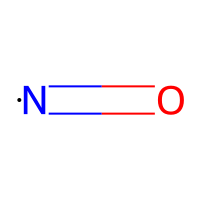
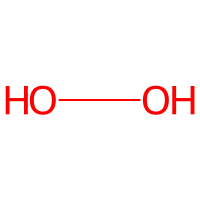
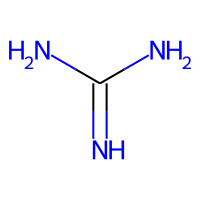
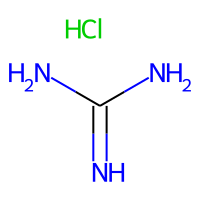
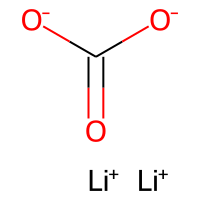

In [13]:
# Creating a ROMol column from SMILES format
PandasTools.AddMoleculeColumnToFrame(approved_drugs_df, smilesCol='SMILES')
print("The size of the main dataset: ", approved_drugs_df.shape[0])
approved_drugs_df.head(5)

,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,withdrawn_year,natural_product,oral,parenteral,topical,ROMol,mw
24,GUANIDINE HYDROCHLORIDE,Cl.N=C(N)N,CHEMBL1200728,1939.0,Small molecule,NaN,0,False,0,True,NaN,0,True,False,False,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",95.025025
36,LITHIUM CARBONATE,O=C([O-])[O-].[Li+].[Li+],CHEMBL1200826,1970.0,Small molecule,Antimanic,0,False,0,True,NaN,0,True,False,False,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",74.016753
41,ACETOHYDROXAMIC ACID,CC(=O)NO,CHEMBL734,1983.0,Small molecule,Enzyme Inhibitor (urease),0,False,0,True,NaN,0,True,False,False,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",75.032028
42,HYDROXYUREA,NC(=O)NO,CHEMBL467,1967.0,Small molecule,Antineoplastic,0,False,0,True,NaN,0,True,False,False,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",76.027277
43,CYSTEAMINE BITARTRATE,NCCS.O=C(O)C(O)C(O)C(=O)O,CHEMBL2062263,1994.0,Small molecule,NaN,0,False,0,True,NaN,0,True,False,False,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",227.046358
44,CYSTEAMINE HYDROCHLORIDE,Cl.NCCS,CHEMBL1256137,2012.0,Small molecule,Anti-Urolithic (cystine calculi),0,False,0,True,NaN,0,False,False,True,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",113.006598
45,CYSTEAMINE,NCCS,CHEMBL602,1994.0,Small molecule,Anti-Urolithic (cystine calculi),0,False,0,True,NaN,0,True,False,True,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",77.029920
50,DIMETHYL SULFOXIDE,C[S+](C)[O-],CHEMBL504,1978.0,Small molecule,Anti-Inflammatory (topical),0,False,0,True,NaN,0,False,True,False,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",78.013936
54,FOMEPIZOLE,Cc1cn[nH]c1,CHEMBL1308,1997.0,Small molecule,Antidote (alcohol dehydrogenase inhibitor),0,False,0,True,NaN,0,False,True,False,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",82.053098
62,LACTIC ACID,CC(O)C(=O)O,CHEMBL1200559,2006.0,Small molecule,NaN,0,False,0,True,NaN,0,False,True,False,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",90.031694

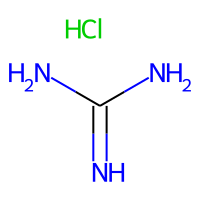
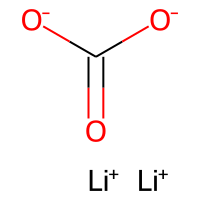
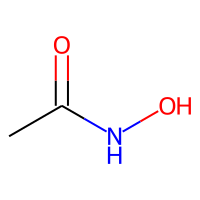
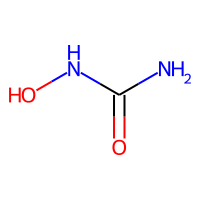
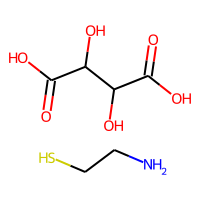
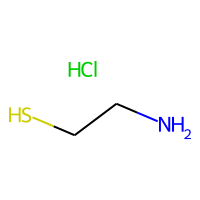
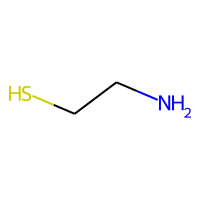
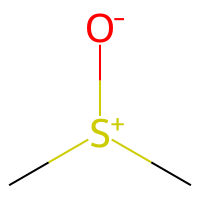
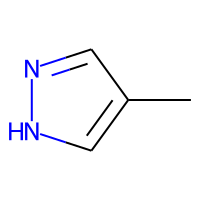
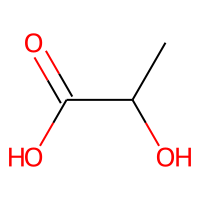

In [35]:
# Calculating the Molecular Weight
approved_drugs_df['mw'] = approved_drugs_df['ROMol'].apply(Descriptors.ExactMolWt)

# Dropping molecules lower than 60 Da
approved_drugs_df = approved_drugs_df.query('mw >= 60').copy()
approved_drugs_df.head(10)

Now we can do some tweaking into our dataframe:
* **Rounding** the number of approval date (just for aesthetic)
* Reseting the index


 Index(['pref_name', 'SMILES', 'molecule_chembl_id', 'first_approval',
       'molecule_type', 'indication_class', 'polymer_flag', 'withdrawn_flag',
       'inorganic_flag', 'therapeutic_flag', 'withdrawn_year',
       'natural_product', 'oral', 'parenteral', 'topical', 'ROMol', 'mw'],
      dtype='object') 

The dataset has the shape (2377, 17)


,pref_name,SMILES,molecule_chembl_id,first_approval,molecule_type,indication_class,polymer_flag,withdrawn_flag,inorganic_flag,therapeutic_flag,withdrawn_year,natural_product,oral,parenteral,topical,ROMol,mw
0,GUANIDINE HYDROCHLORIDE,Cl.N=C(N)N,CHEMBL1200728,1939,Small molecule,NaN,0,False,0,True,NaN,0,True,False,False,,95.025025
1,LITHIUM CARBONATE,O=C([O-])[O-].[Li+].[Li+],CHEMBL1200826,1970,Small molecule,Antimanic,0,False,0,True,NaN,0,True,False,False,,74.016753
2,ACETOHYDROXAMIC ACID,CC(=O)NO,CHEMBL734,1983,Small molecule,Enzyme Inhibitor (urease),0,False,0,True,NaN,0,True,False,False,,75.032028
3,HYDROXYUREA,NC(=O)NO,CHEMBL467,1967,Small molecule,Antineoplastic,0,False,0,True,NaN,0,True,False,False,,76.027277
4,CYSTEAMINE BITARTRATE,NCCS.O=C(O)C(O)C(O)C(=O)O,CHEMBL2062263,1994,Small molecule,NaN,0,False,0,True,NaN,0,True,False,False,,227.046358
5,CYSTEAMINE HYDROCHLORIDE,Cl.NCCS,CHEMBL1256137,2012,Small molecule,Anti-Urolithic (cystine calculi),0,False,0,True,NaN,0,False,False,True,,113.006598
6,CYSTEAMINE,NCCS,CHEMBL602,1994,Small molecule,Anti-Urolithic (cystine calculi),0,False,0,True,NaN,0,True,False,True,,77.029920
7,DIMETHYL SULFOXIDE,C[S+](C)[O-],CHEMBL504,1978,Small molecule,Anti-Inflammatory (topical),0,False,0,True,NaN,0,False,True,False,,78.013936
8,FOMEPIZOLE,Cc1cn[nH]c1,CHEMBL1308,1997,Small molecule,Antidote (alcohol dehydrogenase inhibitor),0,False,0,True,NaN,0,False,True,False,,82.053098
9,LACTIC ACID,CC(O)C(=O)O,CHEMBL1200559,2006,Small molecule,NaN,0,False,0,True,NaN,0,False,True,False,,90.031694

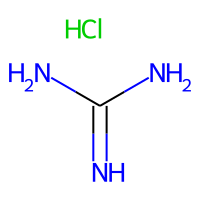
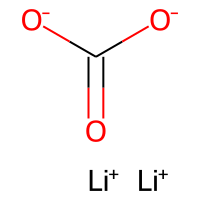
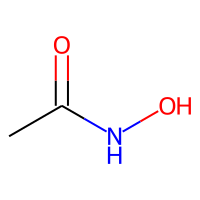
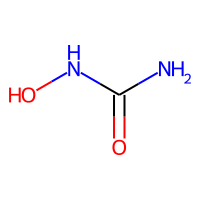
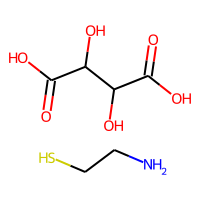
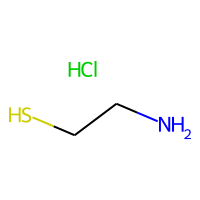
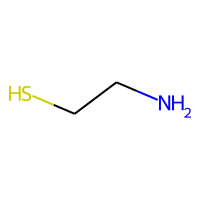
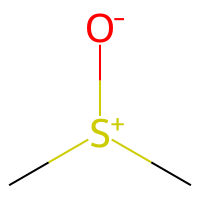
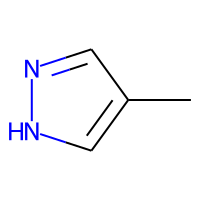
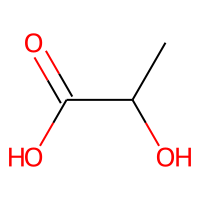
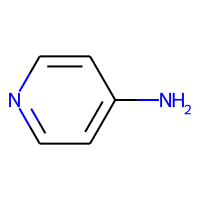
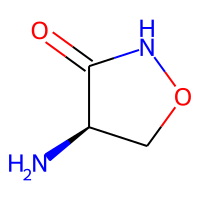
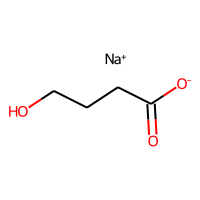
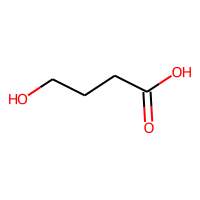
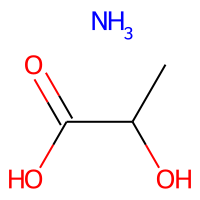
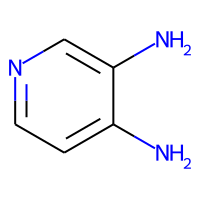
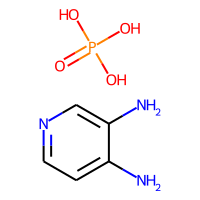
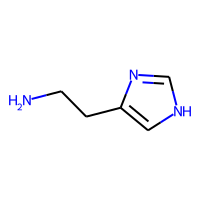
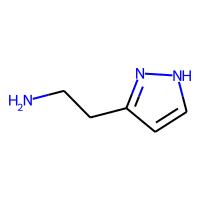
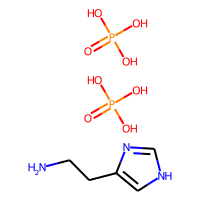

In [38]:
#Rounding the datetime and reseting index
approved_drugs_df['first_approval'] = approved_drugs_df['first_approval'].apply(int)
approved_drugs_df.reset_index(drop=True, inplace=True)

# The main dataset:
print("\n", approved_drugs_df.columns, "\n")
print(f"The dataset has the shape {approved_drugs_df.shape}")
show_df(approved_drugs_df.head(20))